# Import Modules and Data

In [ ]:
# ImporModules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Import Data
df = pd.read_csv('encoded_smoten_ethics (1).csv')


In [ ]:
# Delete columns and reformat
df = df.drop(columns=['day_of_week_bind','day_of_week_incident','insured_zip'])
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df['total_claim_amount_indicator'] = (df['total_claim_amount'] >= 20000).astype(int)
df['injury_claim_amount_indicator'] = (df['injury_claim'] >= 3000).astype(int)
df['property_claim_amount_indicator'] = (df['property_claim'] >= 3000).astype(int)
df['vehicle_claim_amount_indicator'] = (df['vehicle_claim'] >= 10000).astype(int)

# Splitting Data

In [ ]:
X = df.drop(columns=["fraud_reported"])  # Replace "target_column" with the name of your target variable
y = df["fraud_reported"]
X = X.drop(columns=['Unnamed0'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df.isnull().values.any()

False

# Random Forest

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'max_depth': trial.suggest_int('max_depth',10,200),
        'min_samples_split': trial.suggest_int('min_samples_split',2,50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,30),
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = RandomForestRegressor(**params)

    error = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
rf_best = study.best_params
print(study.best_value)
print(rf_best)

[I 2024-07-11 12:50:10,356] A new study created in memory with name: no-name-71b34161-e1da-47f2-bccc-24ea1658e708


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-11 12:50:16,650] Trial 0 finished with value: 0.8747035481187699 and parameters: {'n_estimators': 97, 'max_depth': 189, 'min_samples_split': 42, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.8747035481187699.
[I 2024-07-11 12:50:26,502] Trial 1 finished with value: 0.8757605765255759 and parameters: {'n_estimators': 193, 'max_depth': 113, 'min_samples_split': 17, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.8757605765255759.
[I 2024-07-11 12:50:40,080] Trial 2 finished with value: 0.874144955804347 and parameters: {'n_estimators': 216, 'max_depth': 110, 'min_samples_split': 41, 'min_samples_leaf': 27}. Best is trial 1 with value: 0.8757605765255759.
[I 2024-07-11 12:50:50,143] Trial 3 finished with value: 0.8820400007146134 and parameters: {'n_estimators': 154, 'max_depth': 177, 'min_samples_split': 27, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8820400007146134.
[I 2024-07-11 12:51:05,860] Trial 4 finished with value: 0.8761026607698866 and pa

In [ ]:
rf_best = {'n_estimators': 77,
 'max_depth': 76,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

In [ ]:
rf = RandomForestRegressor(**rf_best)
rf = rf.fit(X_train, y_train.values.ravel())
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([1.        , 0.07792208, 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 0.14285714,
       0.        , 1.        , 1.        , 1.        , 0.        ,
       0.        , 0.07792208, 0.        , 0.        , 0.93506494,
       0.01298701, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       0.92207792, 0.        , 0.        , 0.        , 0.        ,
       0.01298701, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.67532468, 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.68831169, 1.        ,
       0.77922078, 0.1038961 , 0.        , 0.        , 1.        ,
       0.87012987, 0.50649351, 0.06493506, 0.        , 1.        ,
       1.        , 0.02597403, 0.06493506, 0.81818182, 1.        ,
       0.        , 1.        , 1.        , 0.        , 0.     

# XGBoost

In [ ]:
def objective(trial):
    params = {
        'objective' : 'binary:logistic',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'lambda': trial.suggest_float('lambda', 0.0, 3.0),
        'alpha': trial.suggest_float('alpha', 0.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'reg:squaredlogerror',
        'learning_rate': trial.suggest_float('learning_rate', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBRegressor(**params)

    error = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
xgb_best = study.best_params
print(study.best_value)
print(xgb_best)

[I 2024-07-11 13:00:12,787] A new study created in memory with name: no-name-87485758-2884-4ea3-971f-890928d43b49


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-11 13:00:14,368] Trial 0 finished with value: 0.8439252700056169 and parameters: {'max_depth': 79, 'lambda': 1.4047453250234843, 'alpha': 2.8914039066705834, 'subsample': 0.4002727951028393, 'learning_rate': 0.32086292116177983, 'colsample_bytree': 0.3139992707356798, 'n_estimators': 121}. Best is trial 0 with value: 0.8439252700056169.
[I 2024-07-11 13:00:19,905] Trial 1 finished with value: 0.866278788625874 and parameters: {'max_depth': 247, 'lambda': 2.6909154433899465, 'alpha': 1.1020249257339194, 'subsample': 0.6282436219048039, 'learning_rate': 0.06701556401294917, 'colsample_bytree': 0.30542558984374646, 'n_estimators': 160}. Best is trial 1 with value: 0.866278788625874.
[I 2024-07-11 13:00:22,360] Trial 2 finished with value: 0.8498035897199999 and parameters: {'max_depth': 162, 'lambda': 0.4378316733812838, 'alpha': 0.25374124227012607, 'subsample': 0.18187393885329317, 'learning_rate': 0.04408243422806635, 'colsample_bytree': 0.24811353909764622, 'n_estimators': 

In [ ]:
xgb_best ={'objective' : 'binary:logistic',
  'max_depth': 290,
 'lambda': 0.9611097617003315,
 'alpha': 0.18779939443391647,
 'subsample': 0.7175357885879887,
 'learning_rate': 0.05486364097081667,
 'colsample_bytree': 0.9519842501549686,
 'n_estimators': 134}

In [ ]:
xg_reg = XGBRegressor(**xgb_best)
xg_reg.fit(X_train,y_train)
y_pred_xgb = xg_reg.predict(X_test)
y_pred_xgb

array([0.998609  , 0.05136018, 0.00241671, 0.00721271, 0.99898094,
       0.99897563, 0.0030606 , 0.00571802, 0.9989662 , 0.00525926,
       0.9984034 , 0.9987503 , 0.99895656, 0.99868697, 0.04032094,
       0.00437691, 0.9989587 , 0.9982796 , 0.99329174, 0.00345877,
       0.00547144, 0.07716303, 0.00307633, 0.00275738, 0.97947615,
       0.02004005, 0.9960877 , 0.9930896 , 0.99579453, 0.99902964,
       0.99858415, 0.9974437 , 0.9987081 , 0.00297952, 0.998899  ,
       0.9521918 , 0.00509035, 0.00231694, 0.00327096, 0.00638101,
       0.03202301, 0.00209685, 0.00172767, 0.0030606 , 0.0038513 ,
       0.9987081 , 0.5251458 , 0.00245678, 0.01220179, 0.00391691,
       0.99900466, 0.00418194, 0.0038048 , 0.52603644, 0.998609  ,
       0.989368  , 0.0060701 , 0.00567809, 0.00312376, 0.9989214 ,
       0.89898676, 0.45521978, 0.0411129 , 0.0074422 , 0.99648106,
       0.99839157, 0.01461925, 0.03597656, 0.6909922 , 0.9983937 ,
       0.00446763, 0.99692047, 0.99892324, 0.00320347, 0.00628

# LightGBM

In [ ]:
def objective(trial):
    params = {
        'objective' : 'binary',
        'verbosity': -1,
        'max_depth': trial.suggest_int('max_depth',5,300),
        'random_state': 42,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0),
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 1e-9, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',10,300),
        'boosting_type':'gbdt',
        'num_leaves': trial.suggest_int('num_leaves',20,300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = LGBMRegressor(**params)

    error = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2').mean()

    return error

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
lgb_best = study.best_params
print(study.best_value)
print(lgb_best)

[I 2024-07-11 13:08:14,087] A new study created in memory with name: no-name-099a5450-17d6-4d8e-8234-77b29f9902c5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-11 13:08:14,486] Trial 0 finished with value: 0.7702846330269972 and parameters: {'max_depth': 109, 'reg_lambda': 2.608064799564901e-06, 'reg_alpha': 0.20989761693391637, 'subsample': 0.23301784682520754, 'learning_rate': 0.16365086455940606, 'colsample_bytree': 0.005424405145715738, 'n_estimators': 201, 'num_leaves': 64, 'min_child_samples': 47}. Best is trial 0 with value: 0.7702846330269972.
[I 2024-07-11 13:08:15,394] Trial 1 finished with value: 0.8350124614689827 and parameters: {'max_depth': 243, 'reg_lambda': 6.662071330495321e-08, 'reg_alpha': 1.2437388492726151e-05, 'subsample': 0.3793700304421358, 'learning_rate': 0.012879047953687741, 'colsample_bytree': 0.7680304413371054, 'n_estimators': 158, 'num_leaves': 138, 'min_child_samples': 94}. Best is trial 1 with value: 0.8350124614689827.
[I 2024-07-11 13:08:15,756] Trial 2 finished with value: 3.425059875923342e-05 and parameters: {'max_depth': 87, 'reg_lambda': 1.7970475601583137e-06, 'reg_alpha': 0.07073921265197

In [ ]:
lgb_best={'objective' : 'binary',
 'max_depth': 67,
 'reg_lambda': 1.2335682502360708e-06,
 'reg_alpha': 0.0007873842670847208,
 'subsample': 0.6189630411846498,
 'learning_rate': 0.0629492944776372,
 'colsample_bytree': 0.9486190891333371,
 'n_estimators': 96,
 'num_leaves': 232,
 'min_child_samples': 11}

In [ ]:
lgb_reg = LGBMRegressor(**lgb_best)
lgb_reg.fit(X_train,y_train)
y_pred_lgb = lgb_reg.predict(X_test)
y_pred_lgb

[LightGBM] [Info] Number of positive: 1197, number of negative: 1174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 2371, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504850 -> initscore=0.019402
[LightGBM] [Info] Start training from score 0.019402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

array([0.99884855, 0.01324826, 0.00114887, 0.00152337, 0.99885771,
       0.99885771, 0.00123558, 0.00117346, 0.99886125, 0.0011828 ,
       0.99885726, 0.99882825, 0.99885771, 0.99885852, 0.01094345,
       0.00120013, 0.99885771, 0.99885842, 0.99597466, 0.00121928,
       0.00127318, 0.12512557, 0.00114788, 0.00114734, 0.98518303,
       0.00491215, 0.99890815, 0.99812331, 0.99789974, 0.99885771,
       0.99885771, 0.99885804, 0.99885771, 0.00142699, 0.99885771,
       0.99540003, 0.00114839, 0.0011525 , 0.00120932, 0.00140025,
       0.03716194, 0.00120931, 0.00114887, 0.00123558, 0.00114875,
       0.99885771, 0.21573404, 0.00145315, 0.00350756, 0.00201636,
       0.99885771, 0.00113242, 0.00116358, 0.42089752, 0.99884855,
       0.99420546, 0.00234201, 0.00127924, 0.00118602, 0.99885771,
       0.95075755, 0.60033895, 0.00709705, 0.00135463, 0.99830566,
       0.99885804, 0.00148582, 0.01012264, 0.7440694 , 0.99887023,
       0.00118842, 0.99786198, 0.99885771, 0.00118404, 0.00130

# Compare Performance

In [ ]:
from sklearn.metrics import mean_squared_log_error


print("R2 of RF", r2_score(y_test, y_pred_rf))
print("R2 of xgb", r2_score(y_test, y_pred_xgb))
print("R2 of lgbm", r2_score(y_test, y_pred_lgb))

R2 of RF 0.8951577586232405
R2 of xgb 0.8892252664010188
R2 of lgbm 0.8811767157267405


# Ensemble

In [ ]:
y_pred_rf1 = rf.predict(X_train)
y_pred_xgb1 = xg_reg.predict(X_train)
y_pred_lgb1 = lgb_reg.predict(X_train)

In [ ]:
from sklearn.metrics import r2_score
import optuna


def objective(trial):
    # Define parameters to optimize (weights for RF and XGB)
    w_rf = trial.suggest_uniform('w_rf', 0.0, 1.0)
    w_lgb = 1.0 - w_rf  # Ensures weights sum up to 1

    # Combine predictions using the suggested weights
    ensemble_preds = w_rf * y_pred_rf1 + w_lgb * y_pred_lgb1

    # Convert probabilities to binary predictions
    ensemble_binary_preds = [1 if pred >= 0.5 else 0 for pred in ensemble_preds]

    # Evaluate the ensemble model using accuracy (you can choose other metrics as well)
    accuracy = r2_score(y_train, ensemble_binary_preds)

    return accuracy




In [ ]:
# Initialize Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust n_trials as needed

# Get the best parameters
best_w_rf = study.best_params['w_rf']
best_w_lgb = 1.0 - best_w_rf

print(f"Best weights - Random Forest: {best_w_rf}, XGBoost: {best_w_lgb}")
print(f"Best r2: {study.best_value}")

[I 2024-07-11 13:12:24,924] A new study created in memory with name: no-name-a53a265c-982a-4e51-800a-7f9d9e66a826
<ipython-input-21-c6f12ff6ce00>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  w_rf = trial.suggest_uniform('w_rf', 0.0, 1.0)
[I 2024-07-11 13:12:24,932] Trial 0 finished with value: 1.0 and parameters: {'w_rf': 0.20274776493736102}. Best is trial 0 with value: 1.0.
<ipython-input-21-c6f12ff6ce00>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  w_rf = trial.suggest_uniform('w_rf', 0.0, 1.0)
[I 2024-07-11 13:12:24,938] Trial 1 finished with value: 1.0 and parameters: {'w_rf': 0.33508252485010714}. Best is trial 0 with value: 1.0.
<ipython-input-21-c6f12ff6ce00>:7: FutureWarning: suggest_unif

Best weights - Random Forest: 0.20274776493736102, XGBoost: 0.797252235062639
Best r2: 1.0


In [ ]:
ensemble = best_w_rf * y_pred_rf + best_w_lgb * y_pred_lgb
print("R2 of Ensemble", r2_score(y_test, ensemble))
ensemble

R2 of Ensemble 0.8860316327987816


array([9.99082004e-01, 2.63607334e-02, 9.15937378e-04, 1.21451408e-03,
       9.99089309e-01, 9.99089309e-01, 9.85065764e-04, 9.35544814e-04,
       9.99092126e-01, 9.42989193e-04, 9.99088948e-01, 9.99065822e-01,
       9.99089309e-01, 9.99089951e-01, 3.76886577e-02, 9.56803069e-04,
       9.99089309e-01, 9.99089871e-01, 9.96790787e-01, 9.72077311e-04,
       1.01504385e-03, 1.15555165e-01, 9.15148354e-04, 9.14721466e-04,
       9.75021700e-01, 6.54931223e-03, 9.99129518e-01, 9.98503807e-01,
       9.98325563e-01, 9.99089309e-01, 9.99089309e-01, 9.99089566e-01,
       9.99089309e-01, 1.13766976e-03, 9.99089309e-01, 9.80534133e-01,
       9.15557674e-04, 9.18833001e-04, 9.64136598e-04, 1.11635004e-03,
       3.22605282e-02, 9.64122693e-04, 9.15937378e-04, 9.85065764e-04,
       9.15842080e-04, 9.99089309e-01, 3.08915012e-01, 1.15852362e-03,
       2.79640914e-03, 1.60755108e-03, 9.99089309e-01, 9.02827128e-04,
       9.27663760e-04, 4.75115148e-01, 9.99082004e-01, 9.50617795e-01,
      

# Feature Importance

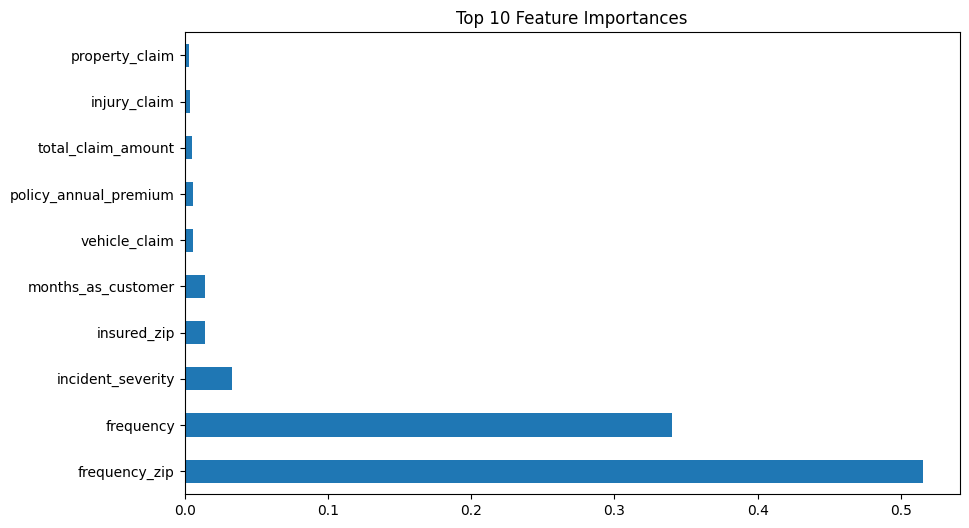

In [ ]:
importances_rf = rf.feature_importances_

feature_names = X.columns  # Assuming X_train is a DataFrame
feature_importances = pd.Series(importances_rf, index=feature_names)

top_features = feature_importances.nlargest(10)
top_features.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.show()

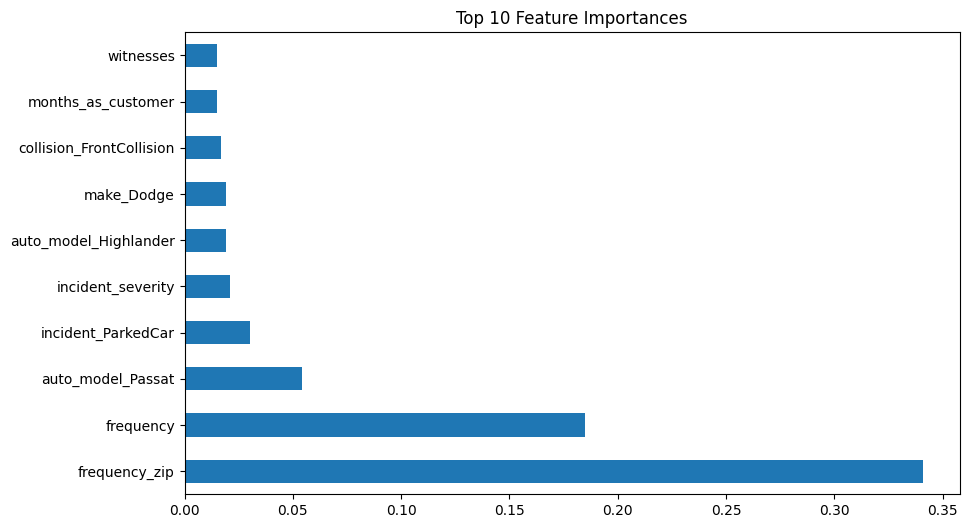

In [ ]:
importances_xg = xg_reg.feature_importances_

feature_names = X.columns  # Assuming X_train is a DataFrame
feature_importances = pd.Series(importances_xg, index=feature_names)

top_features = feature_importances.nlargest(10)
top_features.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.show()


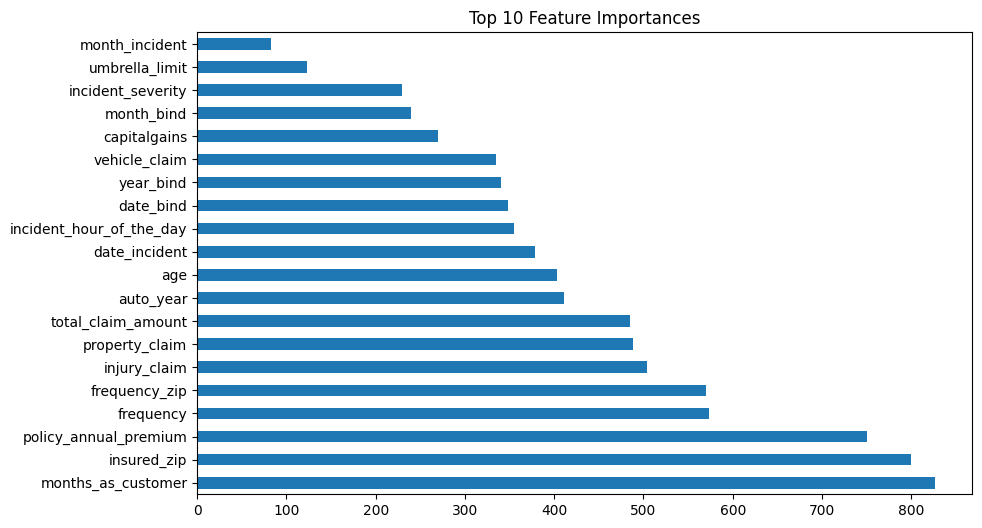

In [ ]:
importances_lgb = lgb_reg.feature_importances_

feature_names = X.columns  # Assuming X_train is a DataFrame
feature_importances = pd.Series(importances_lgb, index=feature_names)

top_features = feature_importances.nlargest(20)
top_features.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.show()
